In [ ]:
!pip install pandas polars matplotlib scikit-learn scipy

In [ ]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10853922 sha256=2228d96c84e9cabf9a6586dab301b035719bd3d268eaf2d491d60e06684adfdf
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [ ]:
!pip install git+https://github.com/daviddavo/lightfm

  Cloning https://github.com/daviddavo/lightfm to /tmp/pip-req-build-swk0b933
  Running command git clone --filter=blob:none --quiet https://github.com/daviddavo/lightfm /tmp/pip-req-build-swk0b933
  Resolved https://github.com/daviddavo/lightfm to commit f0eb500ead54ab65eb8e1b3890337a7223a35114
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp312-cp312-linux_x86_64.whl size=1099142 sha256=c333c433db7845321613a65d8c4f1d4da1c7105afcf6be853503614dbc6917e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-s81gsluo/wheels/fd/89/93/70c1e5f378ee5043de89387ee3ef6852ff39e3b9eb44ecc1a3
Successfully built lightfm


In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from implicit.nearest_neighbours import ItemItemRecommender
from lightfm import LightFM
from lightfm.data import Dataset
from collections import Counter
import pickle

/usr/local/lib/python3.12/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/tmp/pip-install-5z00sbcq/implicit_31f86adddc584d72b1acf0a0ddef892f/./implicit/gpu/utils.h:71)'
  warnings.warn(


## Загрузка данных

In [ ]:
data_folder = "data/"
train = pl.read_parquet(data_folder + "train.pq")
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))
books = pl.read_parquet(data_folder + "books.pq")

print("Train:", train.shape)
display(train.head(5))
print("Test:", test.shape)
display(test.head(5))
print("Books:", books.shape)
display(books.head(5))

Train: (11971437, 5)


user_id,item_id,is_read,rating,date_added
str,i64,bool,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,false,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,false,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,false,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,false,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,false,0,2014-05-15 12:51:20


Test: (185828, 2)


user_id,item_id
str,list[i64]
"""00000377eea48021d3002730d56aca…",[13252]
"""00009ab2ed8cbfceda5a59da409663…",[2328]
"""00009e46d18f223a82b22da38586b6…","[28636, 30197]"
"""0001085188e302fc6b2568de45a5f5…","[2159, 2969, … 33630]"
"""00014c578111090720e20f5705eba0…","[45, 3513, … 33273]"


Books: (34322, 8)


item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"


## EDA

Train stats:
Unique users: 349719
Unique items: 31300
Interactions: 11971437
Avg interactions per user: 34.23
Avg interactions per item: 382.47
Cold items: 1775
Rating distribution:


rating,count
i64,u32
3,906917
0,7649845
1,88344
2,257190
5,1551182
4,1517959


is_read distribution:


is_read,count
bool,u32
false,7279978
true,4691459


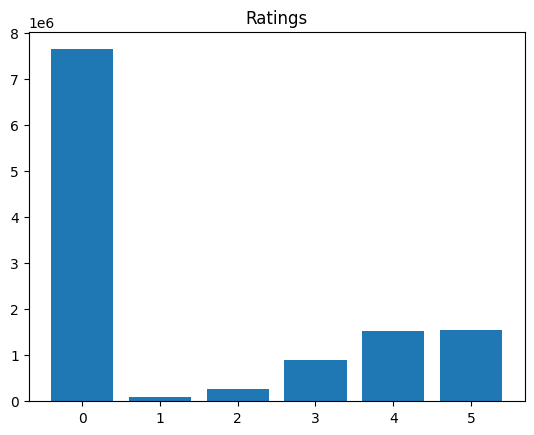

Top tags: [('to-read', 34125), ('young-adult', 33110), ('currently-reading', 29492), ('ya', 27595), ('fiction', 24100), ('favorites', 22233), ('books-i-own', 21406), ('owned', 20581), ('romance', 19068), ('kindle', 17116)]
Top authors: [('2423', 426), ('13730', 208), ('169001', 166), ('50873', 124), ('11654', 121), ('5816', 115), ('3780', 89), ('233309', 85), ('9059', 84), ('19954', 82)]


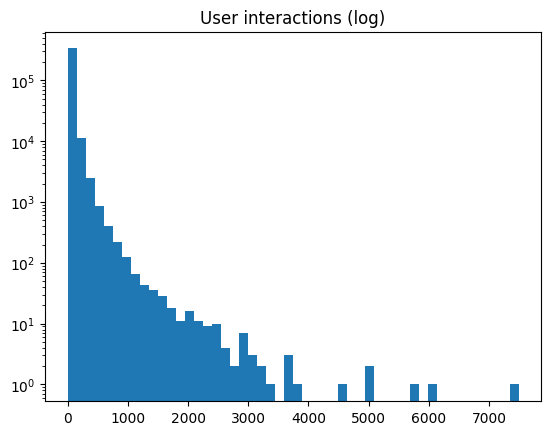

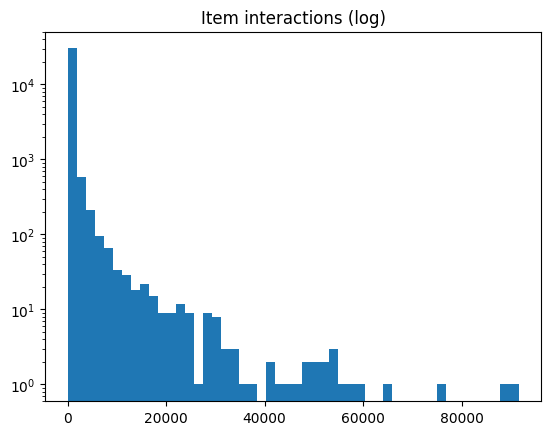

In [ ]:
print("Train stats:")
print(f"Unique users: {train['user_id'].n_unique()}")
print(f"Unique items: {train['item_id'].n_unique()}")
print(f"Interactions: {train.shape[0]}")
print(f"Avg interactions per user: {train.shape[0] / train['user_id'].n_unique():.2f}")
print(f"Avg interactions per item: {train.shape[0] / train['item_id'].n_unique():.2f}")

cold_items = set(test_exploded["item_id"].to_list()) - set(train["item_id"].to_list())
print(f"Cold items: {len(cold_items)}")

test_exploded = test_exploded.with_columns(pl.col("item_id").is_in(list(cold_items)).alias("is_cold"))

rating_counts = train.select(pl.col("rating").value_counts()).unnest("rating")
print("Rating distribution:")
display(rating_counts)

is_read_counts = train.select(pl.col("is_read").value_counts()).unnest("is_read")
print("is_read distribution:")
display(is_read_counts)

plt.bar(rating_counts["rating"], rating_counts["count"])
plt.title("Ratings")
plt.show()

all_tags = [tag for tags in books["tags"].to_list() if tags for tag in tags]
top_tags = Counter(all_tags).most_common(10)
print("Top tags:", top_tags)

all_authors = [a["author_id"] for authors in books["authors"].to_list() if authors for a in authors]
top_authors = Counter(all_authors).most_common(10)
print("Top authors:", top_authors)

user_interactions = train.group_by("user_id").agg(pl.len().alias("interactions")).sort("interactions", descending=True)
plt.hist(user_interactions["interactions"], bins=50, log=True)
plt.title("User interactions (log)")
plt.show()

item_interactions = train.group_by("item_id").agg(pl.len().alias("interactions")).sort("interactions", descending=True)
plt.hist(item_interactions["interactions"], bins=50, log=True)
plt.title("Item interactions (log)")
plt.show()

## Метрики

In [ ]:
from sklearn.metrics import ndcg_score

def recall_at_k(recommended: list, relevant: list, k: int) -> float:
    return len(set(recommended[:k]) & set(relevant)) / len(relevant) if relevant else 0

def ndcg_at_k(recommended: list, relevant: list, k: int) -> float:
    ideal = sorted([1 if i in relevant else 0 for i in recommended], reverse=True)
    scores = np.array([[1 if i in relevant else 0 for i in recommended]])
    ideal_scores = np.array([ideal])
    return ndcg_score(ideal_scores, scores, k=k) if relevant else 0

def coverage(recommended_all: pl.DataFrame, total_items: int) -> float:
    unique_recs = recommended_all["recs"].explode().unique().len()
    return unique_recs / total_items

def cold_recall_at_k(test_df: pl.DataFrame, recs_df: pl.DataFrame, k: int) -> float:
    cold_test = test_df.filter(pl.col("is_cold"))
    if cold_test.shape[0] == 0:
        return 0
    cold_users = cold_test["user_id"].unique()
    cold_recs = recs_df.filter(pl.col("user_id").is_in(cold_users)).select(pl.col("recs").list.head(k))
    cold_relevant = cold_test.group_by("user_id").agg(pl.col("item_id").alias("relevant"))
    recalls = []
    for user in cold_users:
        rec = cold_recs.filter(pl.col("user_id") == user)["recs"].to_list()[0] or []
        rel = cold_relevant.filter(pl.col("user_id") == user)["relevant"].to_list()[0]
        recalls.append(recall_at_k(rec, rel, k))
    return np.mean(recalls) if recalls else 0

def evaluate_model(recs_df: pl.DataFrame, test_df: pl.DataFrame, model_name: str, total_items: int):
    metrics = {"Model": model_name}
    all_recall = []
    all_ndcg = []
    for row in test_df.iter_rows(named=True):
        recs = recs_df.filter(pl.col("user_id") == row["user_id"])["recs"].to_list()[0] or []
        rel = row["item_id"]
        all_recall.append(recall_at_k(recs, rel, 10))
        all_ndcg.append(ndcg_at_k(recs, rel, 10))
    metrics["Recall@10"] = np.mean(all_recall)
    metrics["NDCG@10"] = np.mean(all_ndcg)
    metrics["Coverage"] = coverage(recs_df, total_items)
    metrics["ColdRecall@10"] = cold_recall_at_k(test_exploded, recs_df, 10)
    return metrics

## Popular

In [ ]:
total_items = books["item_id"].n_unique()
popular_items = train.group_by("item_id").agg(pl.len().alias("pop")).sort("pop", descending=True)["item_id"].head(100).to_list()
recs_popular = [popular_items[:10] for _ in range(test.shape[0])]
test = test.with_columns(pl.Series("popular_recs", recs_popular))
pickle.dump(popular_items, open("popular_model.pkl", "wb"))

## ItemKNN (warm)

In [ ]:
# ItemKNN (Warm)
from scipy.sparse import csr_matrix
from implicit.nearest_neighbours import ItemItemRecommender

# Создаём маппинги для пользователей и айтемов
user_ids = train["user_id"].unique().to_list()
item_ids = train["item_id"].unique().to_list()
user_map = {uid: i for i, uid in enumerate(user_ids)}
item_map = {iid: i for i, iid in enumerate(item_ids)}

# Создаём разреженную матрицу user-item
# Приводим data к float64, а row/col к int32 для совместимости с implicit
data = (train["rating"].to_numpy() + 1).astype(np.float64)  # Веса в float64
row = train["user_id"].replace(user_map).to_numpy().astype(np.int32)  # Индексы в int32
col = train["item_id"].replace(item_map).to_numpy().astype(np.int32)  # Индексы в int32
sparse = csr_matrix((data, (row, col)), shape=(len(user_ids), len(item_ids)))

# Обучаем ItemKNN
model_knn = ItemItemRecommender(K=10, num_threads=4)  # num_threads для ускорения
model_knn.fit(sparse)  # Передаём user-item матрицу напрямую

# Генерируем рекомендации
recs_knn = []
for uid in tqdm(test["user_id"], desc="ItemKNN predictions"):
    u_idx = user_map.get(uid, -1)
    if u_idx == -1:
        recs_knn.append(popular_items[:10])  # Fallback на популярные
    else:
        recs, _ = model_knn.recommend(u_idx, sparse[u_idx], N=10, filter_already_liked_items=True)
        recs_knn.append([item_ids[r] for r in recs if r < len(item_ids)] or popular_items[:10])
test = test.with_columns(pl.Series("knn_recs", recs_knn))

# Сохраняем модель
with open("knn_model.pkl", "wb") as f:
    pickle.dump({"model": model_knn, "user_map": user_map, "item_map": item_map, "item_ids": item_ids}, f)

  0%|          | 0/31300 [00:00<?, ?it/s]

ItemKNN predictions: 100%|██████████| 185828/185828 [00:19<00:00, 9641.04it/s] 


## LightFM (Cold & Warm)

In [ ]:
# LightFM (Cold & Warm) с разделением на части
from lightfm import LightFM
from lightfm.data import Dataset
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

# Определяем все айтемы (из train и test)
item_ids = train["item_id"].unique().to_list()
cold_items = list(set(test_exploded["item_id"].to_list()) - set(item_ids))
all_items = list(set(item_ids) | set(cold_items))
user_ids = train["user_id"].unique().to_list()

# Инициализируем dataset
dataset = Dataset()
dataset.fit(users=user_ids, items=all_items)

# Векторизация тегов только для айтемов из all_items
tag_vectorizer = CountVectorizer(max_features=1000)  # Ограничиваем число тегов для экономии памяти
books_filtered = books.filter(pl.col("item_id").is_in(all_items))
tag_matrix = tag_vectorizer.fit_transform(books_filtered["tags"].list.join(" ").to_list())

# Создаём item_features только для отфильтрованных айтемов
item_features = dataset.build_item_features(
    (iid, tag_vectorizer.transform([tags]).toarray()[0])
    for iid, tags in books_filtered.select("item_id", pl.col("tags").list.join(" ")).iter_rows()
)

# Разделяем train на батчи по пользователям
batch_size = 5000  # Количество пользователей в одном батче (настройте под вашу RAM)
user_batches = [user_ids[i:i + batch_size] for i in range(0, len(user_ids), batch_size)]

# Обучаем LightFM с прогресс-баром по батчам
model_lfm = LightFM(loss='warp', no_components=32, random_state=42)  # Уменьшено no_components для экономии памяти
num_epochs = 10  # Уменьшено число эпох для скорости
for batch_idx, batch_users in enumerate(tqdm(user_batches, desc="LightFM training batches")):
    # Фильтруем train для текущего батча пользователей
    batch_train = train.filter(pl.col("user_id").is_in(batch_users))

    # Создаём матрицу взаимодействий для батча
    batch_interactions = dataset.build_interactions(
        (u, i, r + 1) for u, i, r in batch_train.select("user_id", "item_id", "rating").iter_rows()
    )[0]  # Берем только interactions (не weights)

    # Обучаем на батче
    for epoch in tqdm(range(num_epochs), desc=f"LightFM batch {batch_idx + 1} epochs", leave=False):
        model_lfm.fit_partial(batch_interactions, item_features=item_features, epochs=1)

# Сохраняем модель
with open("lfm_model.pkl", "wb") as f:
    pickle.dump({"model": model_lfm, "dataset": dataset, "all_items": all_items, "tag_vectorizer": tag_vectorizer}, f)

LightFM training batches: 100%|██████████| 70/70 [23:45<00:00, 20.36s/it]


## Ансамбль

In [16]:
import pickle
from tqdm import tqdm
from scipy.sparse import csr_matrix

# Select 10% of users from test
test_subset = test.sample(fraction=0.1, seed=42)
test_subset_users = test_subset["user_id"].to_list()

# Filter test_exploded for these users
test_exploded_subset = test_exploded.filter(pl.col("user_id").is_in(test_subset_users))

print("Original test size:", test.shape[0])
print("Test subset size:", test_subset.shape[0])
print("Test exploded subset size:", test_exploded_subset.shape[0])

# Load models
try:
    popular_model = pickle.load(open("popular_model.pkl", "rb"))
    knn_model = pickle.load(open("knn_model.pkl", "rb"))
    lfm_model = pickle.load(open("lfm_model.pkl", "rb"))
except FileNotFoundError as e:
    print(f"Error: Model file not found - {e}")
    raise

# Check structure of popular_model
print("Type of popular_model:", type(popular_model))
if isinstance(popular_model, dict) and "popular_items" in popular_model:
    popular_items = popular_model["popular_items"]
elif isinstance(popular_model, list):
    popular_items = popular_model  # Assume it's the list of popular items
else:
    raise ValueError("Unexpected structure for popular_model. Expected dict with 'popular_items' or list.")

# Create sparse matrix for ItemKNN (if not already defined)
user_ids = train["user_id"].unique().to_list()
item_ids = train["item_id"].unique().to_list()
user_map = {uid: i for i, uid in enumerate(user_ids)}
item_map = {iid: i for i, iid in enumerate(item_ids)}
data = (train["rating"].to_numpy() + 1).astype(np.float64)
row = train["user_id"].replace(user_map).to_numpy().astype(np.int32)
col = train["item_id"].replace(item_map).to_numpy().astype(np.int32)
sparse = csr_matrix((data, (row, col)), shape=(len(user_ids), len(item_ids)))

# Popular predictions
recs_popular = [popular_items[:10] for _ in range(test_subset.shape[0])]
test_subset = test_subset.with_columns(pl.Series("popular_recs", recs_popular))

# ItemKNN predictions
recs_knn = []
for uid in tqdm(test_subset["user_id"], desc="ItemKNN predictions (subset)"):
    u_idx = knn_model["user_map"].get(uid, -1)
    if u_idx == -1:
        recs_knn.append(popular_items[:10])
    else:
        recs, _ = knn_model["model"].recommend(u_idx, sparse[u_idx], N=10, filter_already_liked_items=True)
        recs_knn.append([knn_model["item_ids"][r] for r in recs if r < len(knn_model["item_ids"])] or popular_items[:10])
test_subset = test_subset.with_columns(pl.Series("knn_recs", recs_knn))

# LightFM predictions
recs_lfm = []
user_mapping, _, item_mapping, _ = lfm_model["dataset"].mapping()
for uid in tqdm(test_subset["user_id"], desc="LightFM predictions (subset)"):
    u_idx = user_mapping.get(uid)
    if u_idx is None:
        recs_lfm.append(popular_items[:10])
    else:
        scores = lfm_model["model"].predict(u_idx, np.arange(len(lfm_model["all_items"])))
        top = np.argsort(-scores)[:10]
        recs_lfm.append([lfm_model["all_items"][top_i] for top_i in top])
test_subset = test_subset.with_columns(pl.Series("lfm_recs", recs_lfm))

Original test size: 185828
Test subset size: 18582
Test exploded subset size: 305880
Type of popular_model: <class 'list'>


LightFM predictions (subset): 100%|██████████| 18582/18582 [08:17<00:00, 37.38it/s]


In [17]:
# Simple ensemble (union)
recs_ensemble = []
for i, row in enumerate(test_subset.iter_rows(named=True)):
    pop = row["popular_recs"]
    knn = row["knn_recs"]
    lfm = row["lfm_recs"]
    ensemble = list(set(pop + knn + lfm))[:10]
    recs_ensemble.append(ensemble)
test_subset = test_subset.with_columns(pl.Series("ensemble_recs", recs_ensemble))

# Weighted ensemble
recs_ensemble_weighted = []
for i, row in enumerate(test_subset.iter_rows(named=True)):
    pop = row["popular_recs"]
    knn = row["knn_recs"]
    lfm = row["lfm_recs"]
    scores = {}
    for j, item in enumerate(pop):
        scores[item] = scores.get(item, 0) + 0.2 * (10 - j)
    for j, item in enumerate(knn):
        scores[item] = scores.get(item, 0) + 0.3 * (10 - j)
    for j, item in enumerate(lfm):
        scores[item] = scores.get(item, 0) + 0.5 * (10 - j)
    ensemble = sorted(scores, key=scores.get, reverse=True)[:10]
    recs_ensemble_weighted.append(ensemble)
test_subset = test_subset.with_columns(pl.Series("ensemble_weighted_recs", recs_ensemble_weighted))

## Оценка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Проверяем структуру test_subset
print("Columns in test_subset before metrics:", test_subset.columns)
if "user_id" not in test_subset.columns:
    raise ValueError("test_subset не содержит колонку 'user_id'. Проверьте предыдущие операции.")
if not any(col in test_subset.columns for col in ["popular_recs", "knn_recs", "lfm_recs", "ensemble_recs", "ensemble_weighted_recs"]):
    print("Ошибка: Ни одна колонка рекомендаций не найдена в test_subset. Доступные колонки:", test_subset.columns)
    print("Проверьте блоки предсказаний и ансамбля (Блоки 2 и 3). Убедитесь, что with_columns добавляет колонки 'popular_recs', 'knn_recs', 'lfm_recs', 'ensemble_recs', 'ensemble_weighted_recs'.")
    raise ValueError("Не удалось вычислить метрики: отсутствуют колонки рекомендаций в test_subset.")

# Проверяем наличие test_exploded_subset для ColdRecall@10
if 'test_exploded_subset' not in globals():
    print("Ошибка: test_exploded_subset не определён. Проверьте блок выборки 10% датасета (Блок 1).")
    raise ValueError("test_exploded_subset необходим для вычисления ColdRecall@10.")

# Предполагаем, что total_items определён
total_items = books["item_id"].n_unique()

# Вычисляем метрики
metrics_list = []
for col in ["popular_recs", "knn_recs", "lfm_recs", "ensemble_recs", "ensemble_weighted_recs"]:
    if col not in test_subset.columns:
        print(f"Предупреждение: Колонка {col} не найдена в test_subset. Пропускаем.")
        continue
    try:
        recs_df = test_subset.select("user_id", pl.col(col).alias("recs"))
        metrics = evaluate_model(recs_df, test_subset, col.split("_")[0], total_items)
        metrics_list.append(metrics)
    except Exception as e:
        print(f"Ошибка при вычислении метрик для {col}: {str(e)}")

if not metrics_list:
    print("Ошибка: Не удалось вычислить ни одну метрику. Проверьте, добавлены ли колонки рекомендаций в test_subset.")
    print("Рекомендация: Проверьте логи предсказаний (Блок 2) и ансамбля (Блок 3): длины списков recs_popular, recs_knn, recs_lfm и их содержимое.")
    raise ValueError("Не удалось вычислить метрики: ни одна колонка рекомендаций не обработана.")

metrics_df = pd.DataFrame(metrics_list)
display(metrics_df)

# Визуализация
if not metrics_df.empty:
    plt.figure(figsize=(10, 6))
    metrics_df.set_index("Model")[["Recall@10", "NDCG@10", "Coverage", "ColdRecall@10"]].plot(kind="bar")
    plt.title("Metrics Comparison on 10% Test Subset")
    plt.xlabel("Model")
    plt.ylabel("Metric Value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Визуализация не выполнена: metrics_df пуст.")